In [2]:
import os
import numpy as np
from numpy import genfromtxt
import pickle
import madmom
import matplotlib.pyplot as plt

hfc_func = madmom.features.onsets.high_frequency_content
from madmom.features.onsets import OnsetPeakPickingProcessor

In [3]:
rec_num = "04"

### Sonic Visualizer and MadMom both implement High Frequency Content (HFC)
#### Do they give the same results?


First we look at their detection function and compare to the "true one" as explained in [Masri, 1995]

In [4]:
sig = madmom.audio.Signal('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{}.wav'.format(rec_num))
frames = madmom.audio.FramedSignal(sig, frame_size=512, hop_size=256)
stft = madmom.audio.stft.stft(frames, np.hamming(512))

/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [5]:
hfc_masri = np.sum(np.abs(stft)[:,2:]*np.arange(2,256).reshape((1,-1)),1)
# This should be squared?

In [6]:
hfc_sv = genfromtxt("../results/slurtest04-hfc-function-no-thres.csv", delimiter=',')[:,1]
# Aubio

In [7]:
spect = madmom.audio.spectrogram.Spectrogram('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest04.wav' )
hfc = hfc_func(spect)


In [8]:
print(len(hfc_masri), len(hfc), len(hfc_sv))

2750 1597 2750


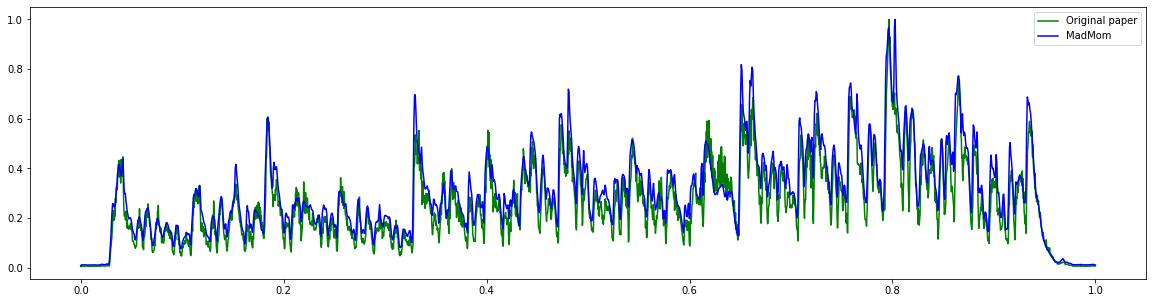

In [9]:
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,1,len(hfc_masri)), hfc_masri/np.max(hfc_masri), 'g')
plt.plot(np.linspace(0,1,len(hfc)), hfc/np.max(hfc), 'b')
plt.legend(["Original paper", "MadMom"])
#plt.plot(np.linspace(0,1,len(hfc_sv)), hfc_sv/np.max(hfc_sv))
plt.show()

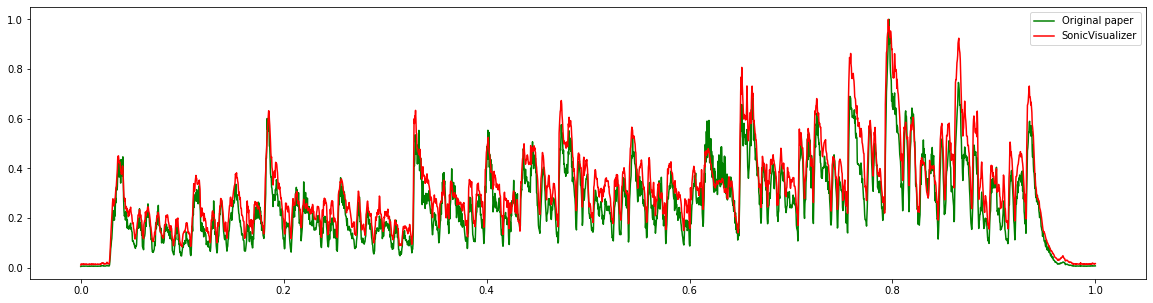

In [10]:
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,1,len(hfc_masri)), hfc_masri/np.max(hfc_masri), 'g')
#plt.plot(np.linspace(0,1,len(hfc)), hfc/np.max(hfc))
plt.plot(np.linspace(0,1,len(hfc_sv)), hfc_sv/np.max(hfc_sv), 'r')
plt.legend(["Original paper", "SonicVisualizer"])
plt.show()

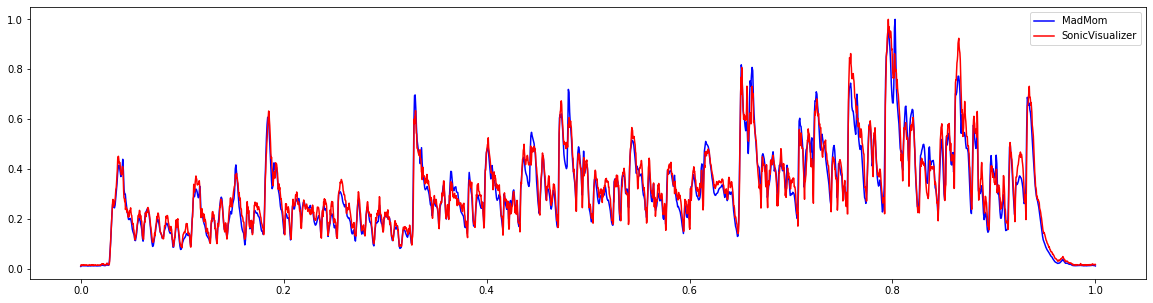

In [11]:
plt.figure(figsize=(20,5))
#plt.plot(np.linspace(0,1,len(hfc_masri)), hfc_masri/np.max(hfc_masri))
plt.plot(np.linspace(0,1,len(hfc)), hfc/np.max(hfc), 'b')
plt.plot(np.linspace(0,1,len(hfc_sv)), hfc_sv/np.max(hfc_sv), 'r')
plt.legend(["MadMom", "SonicVisualizer"])
plt.show()

### Detection functions similar but not identical
> Which one is the "true" HFC?

> Which one should be used?

### How are timepoints extracted?
#### 1. Sonic Visualizer

From SV both detection function and onsets can be exported

In [74]:
onset_times = genfromtxt("datasets/initslurtest_vn/hfc-output/hfc-015-slurtest{}.csv".format(rec_num), delimiter=',')
hfc_sv_thres = genfromtxt("../results/slurtest04-hfc-function.csv", delimiter=',')[:,1]
len(onset_times)

66

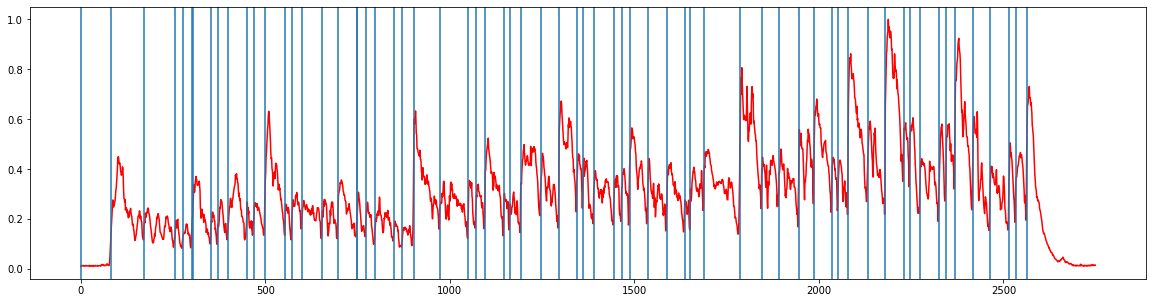

In [75]:
plt.figure(figsize=(20,5))
plt.plot(hfc_sv/np.max(hfc_sv), 'r')
for i in range(len(onset_times)):
    plt.axvline(x=onset_times[i]*172.29)

> Onsets are local minima of detection function

#### 2. MadMom

In [82]:
# Not want to find peaks but derivative peaks
onset_mm = madmom.features.onsets.peak_picking(
    hfc_sv/np.max(hfc_sv), 
    0.07, 
    smooth=5, 
    pre_avg=5, 
    post_avg=1, 
    pre_max=5, 
    post_max=1
)
len(onset_mm)

80

In [122]:
(onset_times*172.29).astype(int)

array([   0,   80,  171,  256,  275,  300,  303,  352,  370,  398,  449,
        468,  498,  554,  571,  599,  653,  697,  747,  749,  772,  797,
        849,  871,  901,  972, 1050, 1070, 1095, 1146, 1162, 1191, 1245,
       1295, 1344, 1361, 1389, 1444, 1465, 1486, 1536, 1588, 1635, 1651,
       1688, 1785, 1845, 1891, 1945, 1987, 2035, 2052, 2079, 2131, 2180,
       2229, 2246, 2274, 2326, 2344, 2369, 2417, 2463, 2514, 2533, 2563])

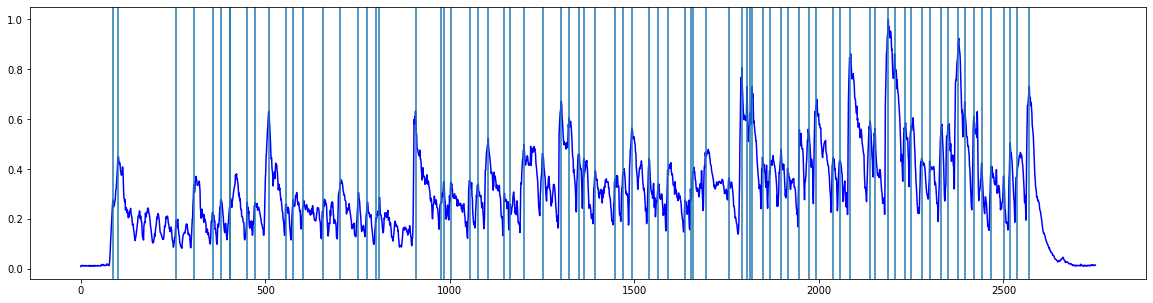

In [84]:
plt.figure(figsize=(20,5))
plt.plot(hfc_sv/np.max(hfc_sv), 'b')
for i in range(len(onset_mm)):
    plt.axvline(x=onset_mm[i])

> Here onsets are local maxima of detection function

#### 3. SonicVisualizer onsets vs Madmom onsets

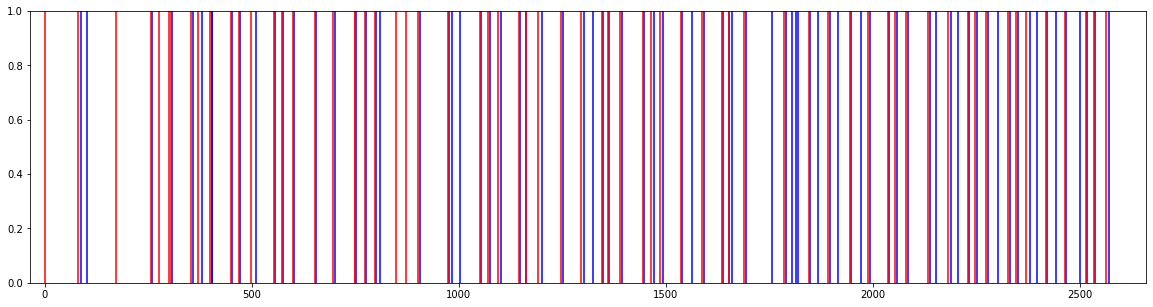

In [88]:
plt.figure(figsize=(20,5))
for i in range(len(onset_mm)):
    plt.axvline(x=onset_mm[i], c='b')
    
for i in range(len(onset_times)):  
    plt.axvline(x=onset_times[i]*172.29, c='r')
    

> Onsets from one algorithm alternates with results from the other - they clearly don't extract peaks in the same way

## Which extraction method is best?
Which result correlates with annotations?

In [76]:
true_onsets = genfromtxt("datasets/initslurtest_vn/initslurtest_vn_annotations/{}.txt".format(rec_num), delimiter=',')

In [106]:
onset_mm[:23]

array([ 87, 102, 258, 307, 357, 379, 403, 405, 451, 472, 509, 556, 575,
       602, 655, 701, 752, 776, 800, 809, 907, 975, 983])

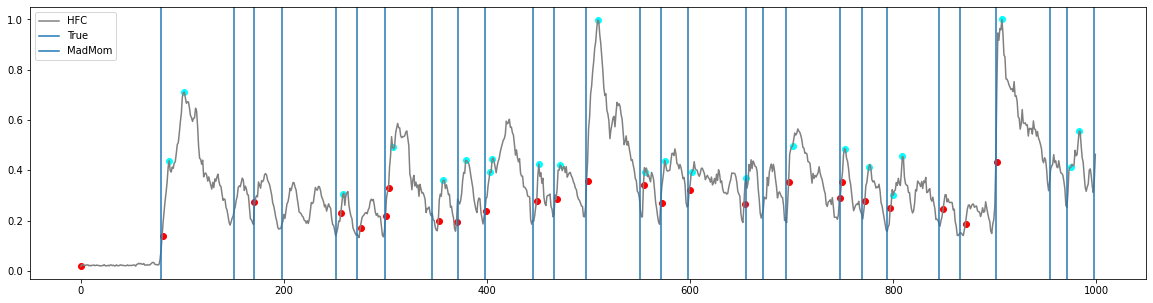

In [127]:
plt.figure(figsize=(20,5))
cur_hfc = hfc_sv[:1000]/np.max(hfc_sv[:1000])
plt.plot(cur_hfc, 'gray')
for i in range(len(true_onsets)):
    if true_onsets[i]<1000/172.29:
        plt.axvline(x=172.29*true_onsets[i])
plt.scatter(onset_mm[:23], cur_hfc[onset_mm[:23]], c="cyan")
plt.scatter((onset_times*172.29)[:25], cur_hfc[(onset_times*172.29).astype(int)[:25]], c="red")
        
# Gray plot - sonic visualizer detection function
# Blue dots - Detected onsets by MadMom
# Red dots - Detections by SonicVisualizer
# Vertical Lines - annotated onsets

> Sonic Visualizer peak processing is more accurate

### How are they doing the peak extraction in SV?

I want to automate HFC and not have to open SV each time